<a href="https://colab.research.google.com/github/jmdelvecchio/ears33/blob/main/Urbanization_and_flood_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


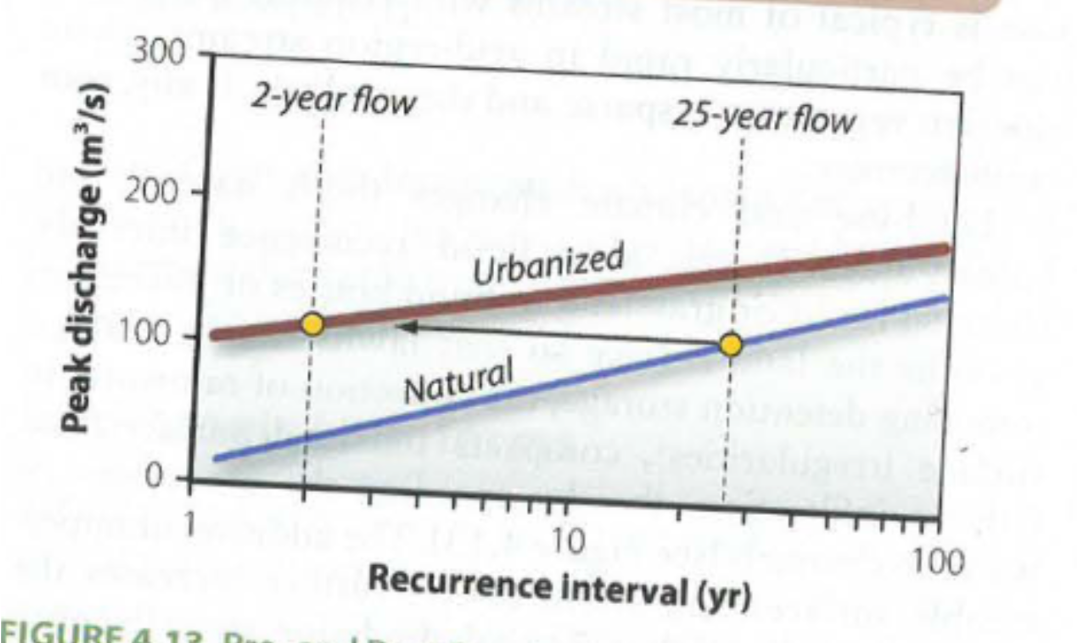

Remember this figure from the textbook? This data tutorial explores the relationship between urbanization and flood risk. I perform a case study of three different watersheds in Houston, each with different levels of urbanization, during Tropical Storm Imelda in 2019. The end goal is to understand how long it takes for a given volume of precipitation to pass through the watershed. Less time means higher flood risk.

Watershed shapefiles, land cover data, and discharge data come from the USGS. Precipitation data comes from the Harris County Flood Warning System. Data for Chocolate Bayou was not available with the HCFWS, but I wanted to include it because it is one of the least urbanized watersheds in the Houston area. I estimated precipitation for Chocolate Bayou from a NOAA figure. 

Harris County Flood Warning System: https://www.harriscountyfws.org

USGS National Water Dashboard: https://dashboard.waterdata.usgs.gov/app/nwd/?region=lower48&aoi=default

Watershed Boundary Dataset: https://www.usgs.gov/national-hydrography/access-national-hydrography-products. I downloaded watershed boundaries for the entire country and deleted all but the ones in the Houston area. 

National Land Cover Data: https://www.mrlc.gov/data?f%5B0%5D=category%3Aurban%20imperviousness&f%5B1%5D=region%3Aconus. I downloaded the percent imperviousness data from 2019. 

NOAA figure to estimate precipitation:
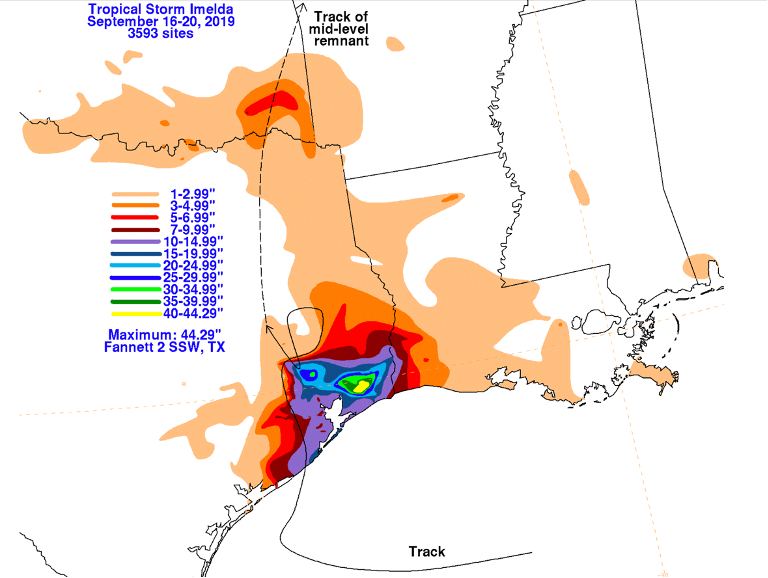

# Retrieve site data

In [ ]:
!pip install dataretrieval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from dataretrieval import nwis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from numpy import trapz


In [ ]:
sitelist = ["08075000", "08069000", "08078000"] #declare USGS stream gage sites

site_info = nwis.get_record(sites=sitelist, service='site') #get information from NWIS
print('Available data are:\n', site_info.columns.values) # print available data
print('Station names are:\n', site_info['station_nm']) #print station name
print('Station latitudes are:\n', site_info['dec_lat_va']) #print station latitude
print('Station longitudes are:\n', site_info['dec_long_va']) #print station longitude

Available data are:
 ['agency_cd' 'site_no' 'station_nm' 'site_tp_cd' 'lat_va' 'long_va'
 'dec_lat_va' 'dec_long_va' 'coord_meth_cd' 'coord_acy_cd'
 'coord_datum_cd' 'dec_coord_datum_cd' 'district_cd' 'state_cd'
 'county_cd' 'country_cd' 'land_net_ds' 'map_nm' 'map_scale_fc' 'alt_va'
 'alt_meth_cd' 'alt_acy_va' 'alt_datum_cd' 'huc_cd' 'basin_cd' 'topo_cd'
 'instruments_cd' 'construction_dt' 'inventory_dt' 'drain_area_va'
 'contrib_drain_area_va' 'tz_cd' 'local_time_fg' 'reliability_cd'
 'gw_file_cd' 'nat_aqfr_cd' 'aqfr_cd' 'aqfr_type_cd' 'well_depth_va'
 'hole_depth_va' 'depth_src_cd' 'project_no']
Station names are:
 0     Cypress Ck nr Westfield, TX
1      Brays Bayou at Houston, TX
2    Chocolate Bayou nr Alvin, TX
Name: station_nm, dtype: object
Station latitudes are:
 0    30.035775
1    29.697175
2    29.371543
Name: dec_lat_va, dtype: float64
Station longitudes are:
 0   -95.428827
1   -95.412162
2   -95.323048
Name: dec_long_va, dtype: float64


In [ ]:
# for each station, list instantaneous discharge between September 17 and September 30, 2019. 

df = pd.DataFrame()

for i in range(len(sitelist)):
    siteNumber = sitelist[i]
    parameterCode = "00060"
    startDate = "2019-09-17"
    endDate = "2019-09-30"
    df_temp = nwis.get_record(sites=sitelist[i], service='iv', start=startDate, end=endDate, parameterCd='00060')
    df = df.append(df_temp)
    df.replace(-999999.0, np.nan, inplace=True)

df

,00060,00060_cd,site_no
datetime,,,
2019-09-17 00:00:00-05:00,141.0,A,08075000
2019-09-17 00:15:00-05:00,141.0,A,08075000
2019-09-17 00:30:00-05:00,141.0,A,08075000
2019-09-17 00:45:00-05:00,144.0,A,08075000
2019-09-17 01:00:00-05:00,146.0,A,08075000
...,...,...,...
2019-09-30 22:45:00-05:00,35.1,A,08078000
2019-09-30 23:00:00-05:00,35.1,A,08078000
2019-09-30 23:15:00-05:00,35.1,A,08078000


Text(0, 0.5, 'Discharge (ft3)')

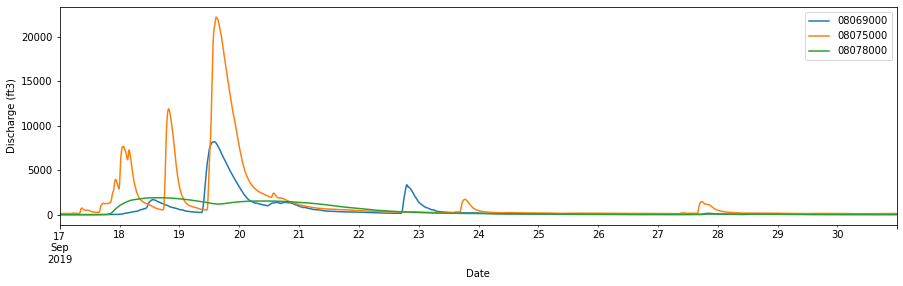

In [ ]:
# plot discharge as a function of time for each station

fig, ax = plt.subplots(figsize=(15,4))

for site, group in df.groupby(by='site_no'):

    group.plot(y='00060', ax=ax, legend=True, label=site)

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (ft3)')

# Find cumulative discharge

In [ ]:
# calculate cumulative discharge for each station within the date range

df["cumulative_q"]=df.groupby(['site_no'])['00060'].cumsum(axis=0)
print(df)

                           00060 00060_cd   site_no  cumulative_q
datetime                                                         
2019-09-17 00:00:00-05:00  141.0        A  08075000         141.0
2019-09-17 00:15:00-05:00  141.0        A  08075000         282.0
2019-09-17 00:30:00-05:00  141.0        A  08075000         423.0
2019-09-17 00:45:00-05:00  144.0        A  08075000         567.0
2019-09-17 01:00:00-05:00  146.0        A  08075000         713.0
...                          ...      ...       ...           ...
2019-09-30 22:45:00-05:00   35.1        A  08078000      671120.3
2019-09-30 23:00:00-05:00   35.1        A  08078000      671155.4
2019-09-30 23:15:00-05:00   35.1        A  08078000      671190.5
2019-09-30 23:30:00-05:00   34.5        A  08078000      671225.0
2019-09-30 23:45:00-05:00   34.8        A  08078000      671259.8

[4032 rows x 4 columns]


In [ ]:
# list maximum discharge for each site

max_cumulative_q = df.groupby(['site_no']).max().reset_index()
max_cumulative_q

,site_no,00060,00060_cd,cumulative_q
0,08069000,8220.0,A,777456.8
1,08075000,22200.0,A,1846310.0
2,08078000,1930.0,A,671259.8


# Prepare Final Plot

To find average precipitation:

I found the average precipitation using data from Harris County Flood Warning System. I recorded precipitation upstream of the USGS gage I used for discharge data until the stream ended. An example of selected precipitation gages can be seen in the figure below. I then averaged those values. 

I was unable to find precipitation values for Chocolate Bayou, but wanted to include it as it is among the least urbanized watersheds in the Houston area. I estimated precipitation based on the figure from NOAA. 

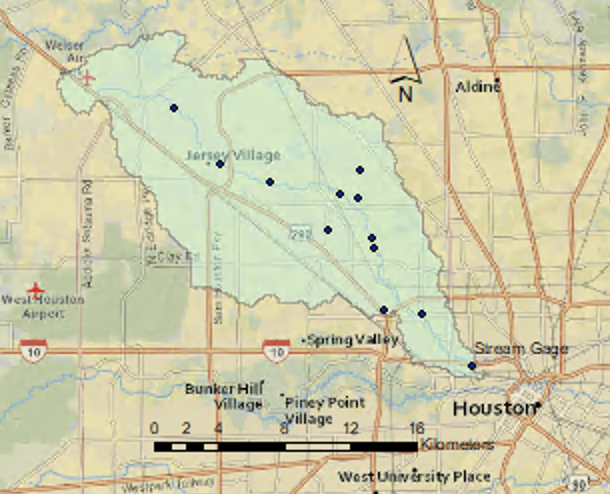

In [ ]:
# calculate the threshold discharge you will be looking at

precipitation = (5.055)*0.0254 #insert average precipitation in inches, convert average precipitaton to meters
area = 328900000 #m2, insert area of watershed in m2

total_volume = precipitation*area #m3, find the total volume of water passing through the watershed
print(total_volume)
threshold = total_volume*0.00027017 #apply a given percentage to the total volume
threshold_f3 = threshold*35.315 #convert volume to f3
print(threshold_f3) #create horizontal lines in the next block where y=threshold_f3 for each watershed

42229773.3
402916.52845966024


I established the percentage used (0.027%) by taking the maximum cumulative discharge for Chocolate Bayou according to stream gage data and dividing it by the total volume calculation. I then applied that same percentage to the other watersheds. This was done because there are large discrepancies between the total volume calculation and stream gage calculations - likely due to factors such as ground water discharge and sewer runoff. 

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7feb75e51d10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7feb758f8210> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7feb758d6150> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


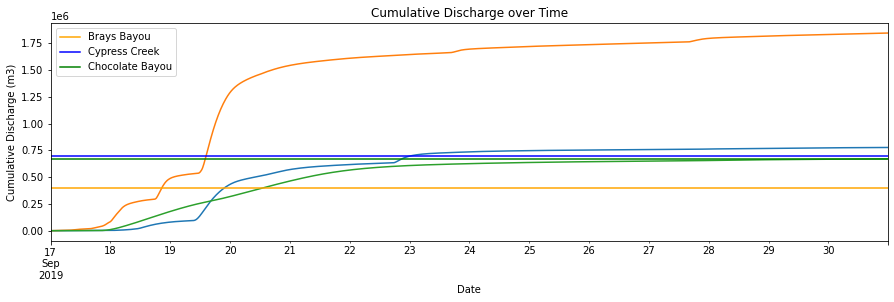

In [ ]:
# plot cumulative discharge for each station over the date range

fig, ax = plt.subplots(figsize=(15,4))

for site, group in df.groupby(by='site_no'):

    group.plot(y='cumulative_q', ax=ax,label='_nolegend_')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Discharge (m3)')
plt.title('Cumulative Discharge over Time')

#plot threshold discharges
plt.axhline(y=402916.53, color='orange', linestyle='-', label="Brays Bayou") #brays
plt.axhline(y=697646.033, color='b', linestyle='-', label="Cypress Creek") #cypress
plt.axhline(y=671259.8, color='g', linestyle='-', label="Chocolate Bayou")#chocolate
plt.legend(loc="upper left")
plt.show()


To find percent imperviousness:

I imported Houston watersheds and National Land Cover Data into ArcMap. I used the extract by mask tool to find the landcover for each watershed. I then used the Zonal statistics as a table tool to export the data to Excel. In Excel, I found the average percent imperviousness by applying the following equation:
1.	[cell value]*[number of cells with that value] = [total value]
2.	[sum total value]/[sum number of cells] = [average percent imperviousness]



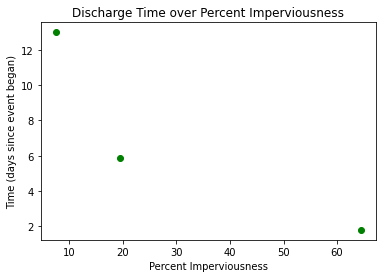

In [ ]:
#create scatter plot of time vs. percent imperviousness

#order of data points must correspond
time=[1.8, 5.9, 13] #list time to reach threshold discharge in decimal days, determined visually from preceding graph
percent_imperviousness=[64.39, 19.40, 7.53] #list percent imperviousness of each watershed

plt.xlabel('Percent Imperviousness')
plt.ylabel('Time (days since event began)')
plt.title('Discharge Time over Percent Imperviousness')
plt.scatter(percent_imperviousness, time, color = 'g')

# Reflection Question

What kind of relationship do you think this is (linear, exponential, logarithmic, etc.)? What would that relationship imply about the impact of urbanization on flood risk?

To me, this appears to be a logarithmic relationship. This suggests that there is a certain point at which an increase in impervious surfaces has little impact on flood risk. The difference between Chocolate Bayou (7% impervious) and Cypress Creek (20% impervious) is dramatic - 13 days vs. 6 days. On the other hand, the difference between Cypress Creek and Brays Bayou (65% impervious) is only about 4 days. The difference in percent imperviousness is much greater between Cypress Creek and Brays Bayou, but the difference between discharge time is much smaller than between Chocolate Bayou and Cypress Creek. This could mean that even a relatively low percent imperviousness can have an extreme impact on flood risk.